In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
# from torch.utils.tensorboard import SummaryWriter

from PIL import Image
from skimage.color import rgba2rgb
import cv2
from IPython.display import display, clear_output
from math import *
import time

from os import makedirs, path
from copy import deepcopy

from tqdm import tqdm

from multilayer_iafCA import multilayer_iafCA
import pygame

pygame 2.0.1 (SDL 2.0.14, Python 3.9.9)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
def LMB_make(state, r=5, s=1):
    '''
    left click to make
    r: radius of brush
    s: smoothing / sigma
    '''
    xcl, ycl = pygame.mouse.get_pos()
    xcl, ycl = int(xcl/UPSCALE), int(ycl/UPSCALE)
    
    # radial blur
    xm, ym = torch.meshgrid(torch.linspace(-1, 1, 2*r), torch.linspace(-1, 1, 2*r))
    rm = torch.sqrt(xm**2 + ym**2).type(torch.double)
    blur = torch.exp(-rm**2 / s**2)
    blur = torch.where(rm <= 1., blur, 0.) # circular mask
    
    xslice = range(xcl - r, xcl + r)
    yslice = range(ycl - r, ycl + r)
    for count_i, i in enumerate(xslice):
        for count_j, j in enumerate(yslice):
            i = i % RESX
            j = j % RESY
            state[0][:, 1, j, i] = state[0][:, 1, j, i] + 0.2
    return state
    
    
def RMB_del(state, r=5, s=1):
    '''
    right click to erase
    r: radius of eraser
    s: smoothing / sigma
    '''
    xcl, ycl = pygame.mouse.get_pos()
    xcl, ycl = int(xcl/UPSCALE), int(ycl/UPSCALE)
    
    # radial blur
    xm, ym = torch.meshgrid(torch.linspace(-1, 1, 2*r), torch.linspace(-1, 1, 2*r))
    rm = torch.sqrt(xm**2 + ym**2).type(torch.double)
    blur = (1 - torch.exp(-rm**2 / s**2))
    blur = torch.where(rm <= 1., blur, 1.) # circular mask
    
    xslice = range(xcl - r, xcl + r)
    yslice = range(ycl - r, ycl + r)
    for count_i, i in enumerate(xslice):
        for count_j, j in enumerate(yslice):
            i = i % RESX
            j = j % RESY
            state[0][:, 1, j, i] = state[0][:, 1, j, i] - 0.2
    return state

def WHEEL_permute(cdim_order, direction):
    cdim_order = np.mod(np.add(cdim_order, direction), 6)
    
    return cdim_order

# Test

In [3]:
RADIUS=5
kernel_increment = 0.01

# resolution of grid
RESX=640
RESY=480
ca = multilayer_iafCA(RADIUS=RADIUS, input_size=(RESY, RESX)).cuda() 

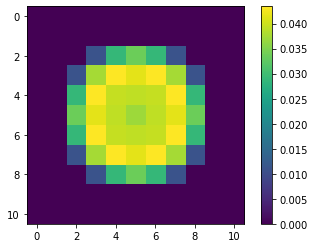

In [4]:
plt.imshow(ca.rule.nearest_neighbours.data[0, 0].cpu().numpy())
plt.colorbar()

In [5]:
# brush properties
r = 20
s = 1

### Init Webcam

In [6]:
cap = cv2.VideoCapture(0)

# Check if the webcam is opened correctly
if not cap.isOpened():
    raise IOError("Cannot open webcam")

# while True:
#     ret, frame = cap.read()
#     frame = cv2.resize(frame, None, fx=0.5, fy=0.5, interpolation=cv2.INTER_AREA)
#     cv2.imshow('Input', frame)

#     c = cv2.waitKey(1)
#     if c == 27:
#         break

# cap.release()
# cv2.destroyAllWindows()

In [7]:
ret, frame = cap.read()
frame = cv2.resize(frame, None, fx=1, fy=1, interpolation=cv2.INTER_AREA)
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

In [ ]:
# pygame stuff
######################################
pygame.init()
size = RESX, RESY
# screen = pygame.display.set_mode(size)
screen = pygame.Surface(size)
UPSCALE = 2
RESXup, RESYup = int(RESX*UPSCALE), int(RESY*UPSCALE)
upscaled_screen = pygame.display.set_mode([RESXup, RESYup])

# webcam stuff
######################################
inject_webcam = False
wbcam_fx = RESX / frame.shape[1]
wbcam_fy = RESY / frame.shape[0]

running = True
time_ticking = True
self_organize = False
LMB_trigger = False
RMB_trigger = False
WHEEL_trigger = False
cdim_order = np.arange(0, 6)

clock = pygame.time.Clock()
font = pygame.font.SysFont("Noto Sans", 12)
def update_fps(clock, font):
    fps = str(int(clock.get_fps()))
    fps_text = font.render(fps, 1, pygame.Color("white"))
    fps_bg = pygame.Surface((fps_text.get_height(),fps_text.get_width()))  # the size of your rect
    fps_bg.set_alpha(50)                # alpha level
    fps_bg.fill((255,255,255))           # this fills the entire surface

    fps_surf = pygame.Surface((fps_bg.get_height(), fps_bg.get_width()))
    fps_surf.blit(fps_bg, (0, 0))
    fps_surf.blit(fps_text, (0, 0))
    return fps_surf
######################################

# CENTER SEED
# seed = torch.cuda.FloatTensor(np.zeros((CHANNELS, RESX, RESY))).unsqueeze(0)
# seed[:, 3:, RESX//2, RESY//2] = 1
# state = seed.clone()

state = ca.initGrid()

# inject noise
signal_injection = torch.zeros(size=ca.rule.input_size)
noise_amp = 1.
noise_idx = slice(4, 10)

update_rate = 1.
ticker = 0.
sink = False
export_imgs = False
imgs = []

with torch.no_grad():
    while running:              
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False
                
            if event.type == pygame.MOUSEBUTTONDOWN:
                if event.button == 1:
                    LMB_trigger = True
                if event.button == 3:
                    RMB_trigger = True
            if event.type == pygame.MOUSEBUTTONUP:
                if event.button == 1:
                    LMB_trigger = False
                if event.button == 3:
                    RMB_trigger = False
                    
            if event.type == pygame.MOUSEWHEEL:
                WHEEL_trigger = True
                direction = -event.y
                
            if event.type== pygame.KEYDOWN and event.key == pygame.K_LEFTBRACKET:
                update_rate += -0.5
            if event.type== pygame.KEYDOWN and event.key == pygame.K_RIGHTBRACKET:
                update_rate += 0.5
            
            if event.type == pygame.MOUSEBUTTONUP and event.button == 2:
                # scroll through channel dims
                cdim_order = np.arange(0, state.shape[1])
                    
#             if event.type == pygame.KEYDOWN and event.key == pygame.K_SPACE:
#                 # pick another random CA
#                 ca = CA(CHANNELS=CHANNELS, FILTERS=FILTERS, NET_SIZE=NET_SIZE, RADIUS=RADIUS).cuda() 
                
                
#             if event.type == pygame.VIDEORESIZE:
#                 print(event.w, event.h)
#                 surface = pygame.display.set_mode((event.w, event.h),
#                                               pygame.RESIZABLE)
            if event.type== pygame.KEYDOWN and event.key == pygame.K_k:
                ca.rule.nearest_neighbours = ca.rule.generate_cppn_kernel()
            if event.type== pygame.KEYDOWN and event.key == pygame.K_UP:
                ca.rule.nearest_neighbours = ca.rule.nearest_neighbours + kernel_increment
            if event.type== pygame.KEYDOWN and event.key == pygame.K_DOWN:
                ca.rule.nearest_neighbours = ca.rule.nearest_neighbours - kernel_increment
            if event.type== pygame.KEYDOWN and event.key == pygame.K_w:
                inject_webcam = not inject_webcam
                
            if event.type== pygame.KEYDOWN and event.key == pygame.K_s:
                sink = not sink
            if event.type== pygame.KEYDOWN and event.key == pygame.K_e:
                export_imgs = not export_imgs
            if event.type== pygame.KEYDOWN and event.key == pygame.K_p:
                # pause/toggle time
                time_ticking = not time_ticking
                
            if event.type== pygame.KEYDOWN and event.key == pygame.K_r:
                # start from seed 
                state = ca.initGrid()
                

        mouse_pos = pygame.mouse.get_pos()
        if LMB_trigger:
            state = LMB_make(state, r=r, s=s)
        if RMB_trigger:
            state = RMB_del(state, r=r, s=s)
            
        if WHEEL_trigger:
            cdim_order = WHEEL_permute(cdim_order, direction)
            WHEEL_trigger = False
            
#         nx = state.cpu()[:, cdim_order].numpy()[0, 0, :, :].transpose(1, 2, 0)
        nx = state[-1].cpu().numpy()[0, cdim_order[0], :, :].transpose()
#         nx = state.cpu()[0, cdim_order].numpy().transpose(1, 2, 0)
        nx = nx * 255.

        if time_ticking:
            state = ca.forward(state)
            ticker += 1
            
            if inject_webcam:
                ret, frame = cap.read()
                frame = cv2.resize(frame, None, fx=wbcam_fx, fy=wbcam_fy, interpolation=cv2.INTER_AREA)
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                state[0][0, 1, 0:frame.shape[0], 0:frame.shape[1]] = state[0][0, 1, 0:frame.shape[0], 0:frame.shape[1]] + torch.cuda.FloatTensor(frame)/255.
    
        if sink and time_ticking:
            xv, yv = torch.linspace(-1, 1, RESX), torch.linspace(-RESY/RESX, RESY/RESX, RESY)
            X, Y = torch.meshgrid(xv, yv)
            amp = 0.00
            w = 30
            R = torch.sqrt(X**2 + Y**2).cuda()
            state = torch.where(R > 0.5, state - 0.5 * torch.ones_like(state).cuda(), state)

        if export_imgs and time_ticking:
            imgs.append(nx)
        

        pygame.surfarray.blit_array(screen, nx)        
        frame = pygame.transform.scale(screen, (RESXup, RESYup))
        upscaled_screen.blit(frame, frame.get_rect())
        upscaled_screen.blit(update_fps(clock, font), (10,0))
        pygame.display.flip()
        clock.tick(60)
        
pygame.quit()


In [ ]:
layer_idx = 0

fig, axes = plt.subplots(2, 3, figsize=(18, 6))
axes = axes.flatten()

axes[0].hist(state[layer_idx][0, 1].cpu().numpy().reshape(-1), 100);
axes[0].set_title('Voltages')
axes[1].hist(state[layer_idx][0, 0].cpu().numpy().reshape(-1), 100);
axes[1].set_title('Spikes')
axes[2].hist(state[layer_idx][0, 2].cpu().numpy().reshape(-1), 100);
axes[2].set_title('Refractory time')

axes[3].hist(state[layer_idx][0, 3].cpu().numpy().reshape(-1), 100)
axes[3].set_title('Trace rate')
axes[4].hist(state[layer_idx][0, 4].cpu().numpy().reshape(-1), 100)
axes[4].set_title('Threshold')
axes[5].hist(state[layer_idx][0, 5].cpu().numpy().reshape(-1), 100)
axes[5].set_title('Energy')

In [ ]:
layer_idx = 1

fig, axes = plt.subplots(2, 3, figsize=(18, 6))
axes = axes.flatten()

axes[0].hist(state[layer_idx][0, 1].cpu().numpy().reshape(-1), 100);
axes[0].set_title('Voltages')
axes[1].hist(state[layer_idx][0, 0].cpu().numpy().reshape(-1), 100);
axes[1].set_title('Spikes')
axes[2].hist(state[layer_idx][0, 2].cpu().numpy().reshape(-1), 100);
axes[2].set_title('Refractory time')

axes[3].hist(state[layer_idx][0, 3].cpu().numpy().reshape(-1), 100)
axes[3].set_title('Trace rate')
axes[4].hist(state[layer_idx][0, 4].cpu().numpy().reshape(-1), 100)
axes[4].set_title('Threshold')
axes[5].hist(state[layer_idx][0, 5].cpu().numpy().reshape(-1), 100)
axes[5].set_title('Energy')

In [ ]:
layer_idx = 2

fig, axes = plt.subplots(2, 3, figsize=(18, 6))
axes = axes.flatten()

axes[0].hist(state[layer_idx][0, 1].cpu().numpy().reshape(-1), 100);
axes[0].set_title('Voltages')
axes[1].hist(state[layer_idx][0, 0].cpu().numpy().reshape(-1), 100);
axes[1].set_title('Spikes')
axes[2].hist(state[layer_idx][0, 2].cpu().numpy().reshape(-1), 100);
axes[2].set_title('Refractory time')

axes[3].hist(state[layer_idx][0, 3].cpu().numpy().reshape(-1), 100)
axes[3].set_title('Trace rate')
axes[4].hist(state[layer_idx][0, 4].cpu().numpy().reshape(-1), 100)
axes[4].set_title('Threshold')
axes[5].hist(state[layer_idx][0, 5].cpu().numpy().reshape(-1), 100)
axes[5].set_title('Energy')

In [ ]:
plt.hist(ca.rule.EI.cpu().numpy().reshape(-1))

In [ ]:
self = ca.rule
x = state

Rk = self.radius
x[:, [0], ...] = x[:, [0], ...] * self.EI
S = F.pad(x[:, [0], ...], (Rk, Rk, Rk, Rk), mode='circular') #spikes
I = F.conv2d(S, self.nearest_neighbours, padding=0)
plt.imshow(I.cpu().numpy()[0, 0].transpose())
plt.colorbar()

In [ ]:
fname = time.strftime("%Y%m%d-%H%M%S")
# out = cv2.VideoWriter(f'videos/CA-{fname}.avi',cv2.VideoWriter_fourcc(*'DIVX'), 60, (RESX, RESY), 3)
out = cv2.VideoWriter(f'videos/CA-{fname}.mp4',cv2.VideoWriter_fourcc(*'MP4V'), 60, (RESX, RESY), 1)


for img in imgs:
#     img = np.uint8(cv2.cvtColor(img, cv2.COLOR_RGB2BGR)*255.0)
    img = np.uint8(cv2.cvtColor(img, cv2.COLOR_RGB2BGR)).transpose(1, 0, 2)
    out.write(img)
out.release()

### Debug stuff

In [ ]:
ret, frame = cap.read()
frame = cv2.resize(frame, None, fx=1., fy=1., interpolation=cv2.INTER_AREA)
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY).transpose()
k=3
s=2


with torch.no_grad():
    A = torch.cuda.FloatTensor(frame).unsqueeze(0).unsqueeze(0)
    print(f"A: {A.shape}")
    layer = nn.Conv2d(1, 1, k, stride=s, padding=0, bias=False).cuda()
    layer_convtrans = nn.ConvTranspose2d(1, 1, k, stride=s, padding=0, bias=False).cuda()
    l1 = layer(A[0:, 0:1, : , :])
    print(f"After the convolution: {l1.shape}")
    l2 = layer_convtrans(l1, output_size=A.size())
    print(f"After the deconvolution: {l2.shape}")

    fig, ax = plt.subplots(1, 3, figsize=(18, 6))
    ax[0].imshow(A.cpu().numpy()[0, 0].transpose())
    ax[1].imshow(l1.cpu().numpy()[0, 0].transpose())
    ax[2].imshow(l2.cpu().numpy()[0, 0].transpose())

In [ ]:
import torch.nn.functional as F
RESX = 1281
RESY = 720
k = 3

with torch.no_grad():
    Ax, Ay = torch.meshgrid(torch.linspace(-1, 1, RESX), RESY/RESX * torch.linspace(-1, 1, RESY))
    A = torch.sin(5 * 3.1415 * torch.sqrt(Ax**2 + Ay **2)).unsqueeze(0).unsqueeze(0).cuda()
    print(f"A: {A.shape}")
    
    conv2d_kernel = torch.ones(size=(1, 1, k, k)).cuda()
    l1 = F.conv2d(A, conv2d_kernel, stride=3, padding=0)
    print(f"After the convolution: {l1.shape}")
    
    transconv2d_kernel = torch.ones(size=(1, 1, k, k)).cuda()
    l2 = F.conv_transpose2d(l1, transconv2d_kernel, stride=3, padding=0)
    print(f"After the deconvolution: {l2.shape}")

    fig, ax = plt.subplots(1, 3, figsize=(18, 6))
    ax[0].imshow(A.cpu().numpy()[0, 0].transpose())
    ax[1].imshow(l1.cpu().numpy()[0, 0].transpose())
    ax[2].imshow(l2.cpu().numpy()[0, 0].transpose())

In [ ]:
import torch.nn.functional as F

ret, frame = cap.read()
frame = cv2.resize(frame, None, fx=1., fy=1., interpolation=cv2.INTER_AREA)
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY).transpose()

k = 3

with torch.no_grad():
    A = torch.cuda.FloatTensor(frame).unsqueeze(0).unsqueeze(0)
    print(f"A: {A.shape}")
    
    conv2d_kernel = torch.ones(size=(1, 1, k, k)).cuda()
    l1 = F.conv2d(A, conv2d_kernel, stride=3, padding=0)
    print(f"After the convolution: {l1.shape}")
    
    transconv2d_kernel = torch.rand(size=(1, 1, k, k)).cuda()
    l2 = F.conv_transpose2d(l1, transconv2d_kernel, stride=3, padding=0)
    print(f"After the deconvolution: {l2.shape}")

    fig, ax = plt.subplots(1, 3, figsize=(18, 6))
    ax[0].imshow(A.cpu().numpy()[0, 0].transpose())
    ax[1].imshow(l1.cpu().numpy()[0, 0].transpose())
    ax[2].imshow(l2.cpu().numpy()[0, 0].transpose())